# Predicting Power Prices in Spain - Group 3
The provided datasets contain the following timeseries with hourly granularity:
* date: date of the observation ”%Y-%m-%d”
* hour: hour of the observation, [0 - 23]
* fc demand: forecast of demand in MWh
* fc nuclear: forecast of nuclear power production in MWh
* import FR: forecast of the importing capacity from France to Spain in MWh
* export FR: forecast of the exporting capacity from Spain to France in MWh
* fc wind: forecast of wind power production in MWh
* fc solar pv: forecast of PV solar (solar panels) power production in MWh
* fc solar th: forecast of thermal solar power production in MWh
* price: power price for each hour in €/MWh. This is the target we want you to predict.

## 1. Environment Setup and Dataset Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('power_market.csv', parse_dates=['date'])
df.head()

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1
2,21893.0,7117.2,3000.0,2650.0,1823.0,0.0,4.6,51.95,2017-01-01,2
3,20693.0,7117.2,3000.0,2650.0,1777.0,0.0,9.7,47.27,2017-01-01,3
4,19599.0,7117.2,3000.0,2650.0,1746.0,0.0,24.1,45.49,2017-01-01,4


## 2. Exploratory Data Analysis
### 2.1 Data types of dataset
A first view at the data types of each column proves useful in later analyses.

In [3]:
df.dtypes

fc_demand             float64
fc_nuclear            float64
import_FR             float64
export_FR             float64
fc_wind               float64
fc_solar_pv           float64
fc_solar_th           float64
price                 float64
date           datetime64[ns]
hour                    int64
dtype: object

### 2.2 Missing values in each column
Now, to examine the amount of missing values in each column.

In [4]:
len(df)

32135

In [5]:
df.isnull().sum()

fc_demand       0
fc_nuclear      0
import_FR      13
export_FR      13
fc_wind         0
fc_solar_pv     0
fc_solar_th     0
price           0
date            0
hour            0
dtype: int64

There is a suprisingly low number of missing values in the dataset. Let's see if they occur at the same time.

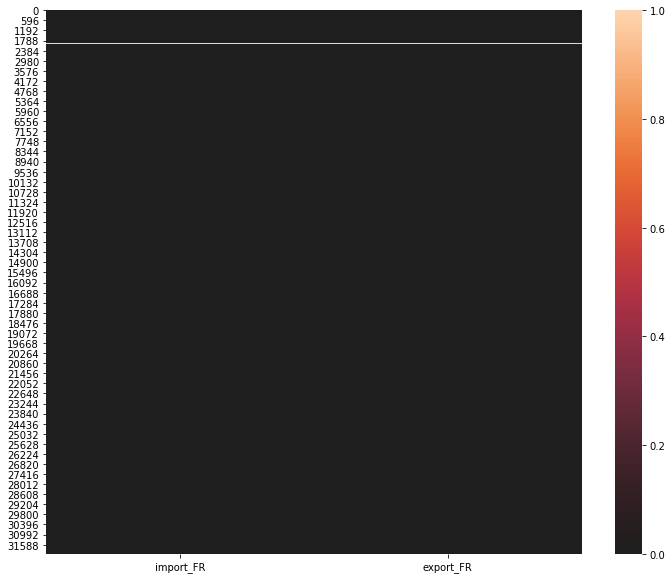

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
nan_mat = sns.heatmap(df[['import_FR', 'export_FR']].isna(), ax=ax, center=0)

At a first glance, we see that the forecasts of the importing and exporting capacities from France to Spain are missing for the same periods of time. Let's take a look at when this happens.

In [16]:
df.loc[df['export_FR'].isna(), ['date', 'hour']]

,date,hour
840,2017-02-05,0
1992,2017-03-25,0
4847,2017-07-22,0
6863,2017-10-14,0
6887,2017-10-15,0
10560,2018-03-17,0
11303,2018-04-17,0
15599,2018-10-13,0
15623,2018-10-14,0
19464,2019-03-23,0


### 2.3 Distribution of each Feature
The dataset is further explored by looking at the distribution of each column in the dataset.
#### 2.3.1 Date column
Starting with the date column:

In [18]:
print(df['date'].min(), df['date'].max())

2017-01-01 00:00:00 2020-08-31 00:00:00


In [19]:
df['date'].nunique()

1339

In [32]:
count_by_date = df[['date', 'hour']].groupby(['date']).count()
count_by_date.loc[(count_by_date != 24)['hour'], :].sort_values(by='hour')

,hour
date,
2017-03-26,23
2018-03-25,23
2019-03-31,23
2020-03-29,23
2017-10-29,25
2018-10-28,25
2019-10-27,25


For this essential column, we can see the following:
* The dataset describes 1339 days, spanning from 2017-01-01 to 2020-08-31.
* There are 3 days with more than 24 hours recorded, and 4 with less than 24 recorded hours. This is probably due to the light-saving time changes.

#### 2.3.2 Hour column
The expected distribution of the hour is fairly uniform. Let's corroborate this.

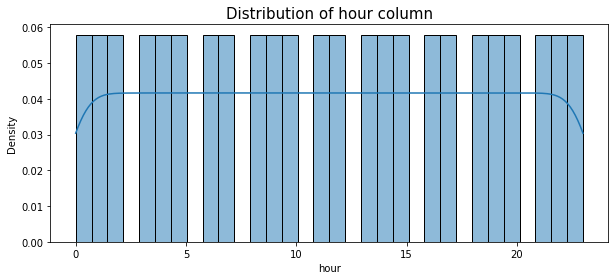

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Distribution of hour column', fontsize=15)
sns.histplot(df['hour'], ax=ax, kde=True, stat='density')
plt.show()

#### 2.3.3 More Relevant Numerical Features
Now let's take a look at where the meat of the dataset is.

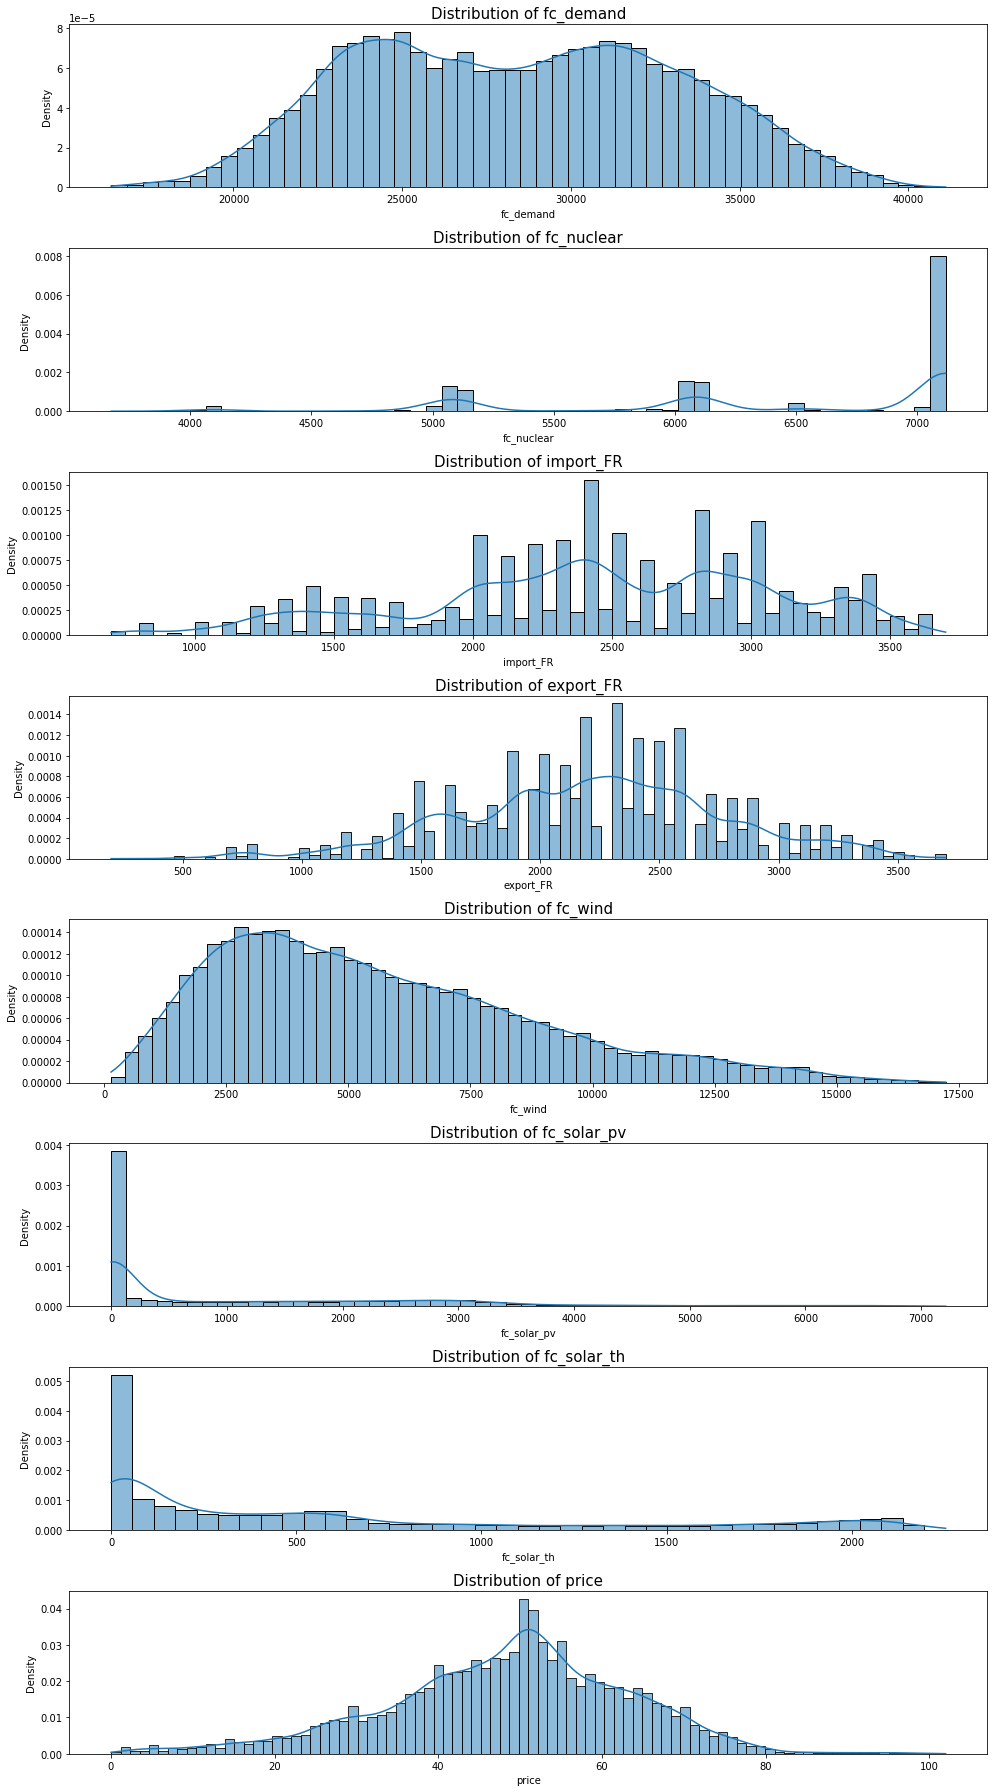

In [40]:
fields = ['fc_demand', 'fc_nuclear', 'import_FR', 'export_FR', 'fc_wind', 'fc_solar_pv', 'fc_solar_th', 'price']
fig, axs = plt.subplots(figsize=(14, 25), ncols=1, nrows=len(fields), sharey=False)
for field, ax in zip(fields, axs):
    ax.set_title('Distribution of ' + field, fontsize=15)
    sns.histplot(df[field], ax=ax, kde=True, stat='density')
fig.tight_layout()

The following insights can be extracted from these distributions:
* **fc_demand:** There are two peaks in the distribution, possibly showing two "modes" of consumption. Under certain conditions, the demand is more similar to the lower peak, whereas under a different configuration, demand tends towards the larger peak. This should be further studied.
* **fc_nuclear:** This distribution adds almost no value, since there around 5 clear modes. The vast majority of the dataset appears for `fc_nuclear = 7000`, whereas other much minoritary modes also exist. It may make sense to transform this variable into a categorical one with 5 categories.
* **export_FR and import_FR:** These two variables show relatively similar distributions, in the sense that they have an irregular density, are largely spread out, and are not particularly skewed.
* **fc_wind:** This variable is significantly right-skewed, sure needing some sort of Box-Cox normalization later on.
* **fc_solar_pv and fc_solar_th:** The great majority of time, these two variables are 0. It may make sense to categorize them, to 0 when the numerical variable is 0, and to 1 when it is not.
* **price:** The dataset's target has a significant peak at 50€/MWh, without any significant skewness.

#### 2.3.1 A closer look at 'fc_demand'
Let's try to find the two modes in demand, based on a split in season.

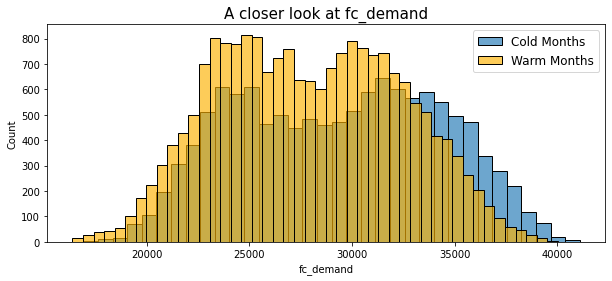

In [77]:
cold_months = df['date'].dt.month.isin([10, 11, 12, 1, 2])
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("A closer look at fc_demand", fontsize=15)
sns.histplot(df.loc[cold_months, 'fc_demand'], ax=ax, kde=False, stat='count', alpha=0.65, label='Cold Months')
sns.histplot(df.loc[~cold_months, 'fc_demand'], ax=ax, kde=False, stat='count', alpha=0.65, color='#fcb100', label='Warm Months')
ax.legend(fontsize=12)
plt.show()

Apparently it's not the season that differentiates these two modes of consumption. Perhaps it is the hour.

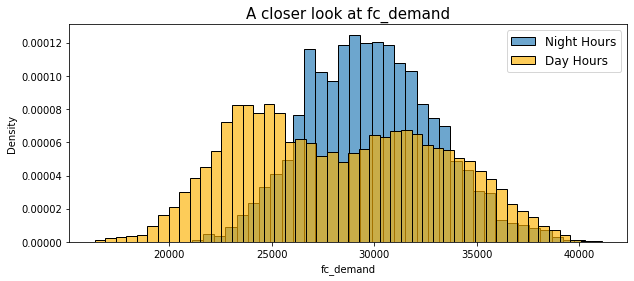

In [79]:
night_hours = df['hour'].isin([21, 22, 23] + [range(0, 8)])
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("A closer look at fc_demand", fontsize=15)
sns.histplot(df.loc[night_hours, 'fc_demand'], ax=ax, kde=False, stat='density', alpha=0.65, label='Night Hours')
sns.histplot(df.loc[~night_hours, 'fc_demand'], ax=ax, kde=False, stat='density', alpha=0.65, color='#fcb100', label='Day Hours')
ax.legend(fontsize=12)
plt.show()

It appears that these two modes of energy consumption, which cause these recurring, persistent peaks in the distribution of 'fc_demand', are not caused by a simple relation defined by 'hour' or season. Further steps of this analysis might shed more light on this issue.

### 2.4 Examining Outliers
To further examine the distribution of these numerical variables, and to visualize and identify possible outlier variables, it is useful to see the Box-plot of each variable.

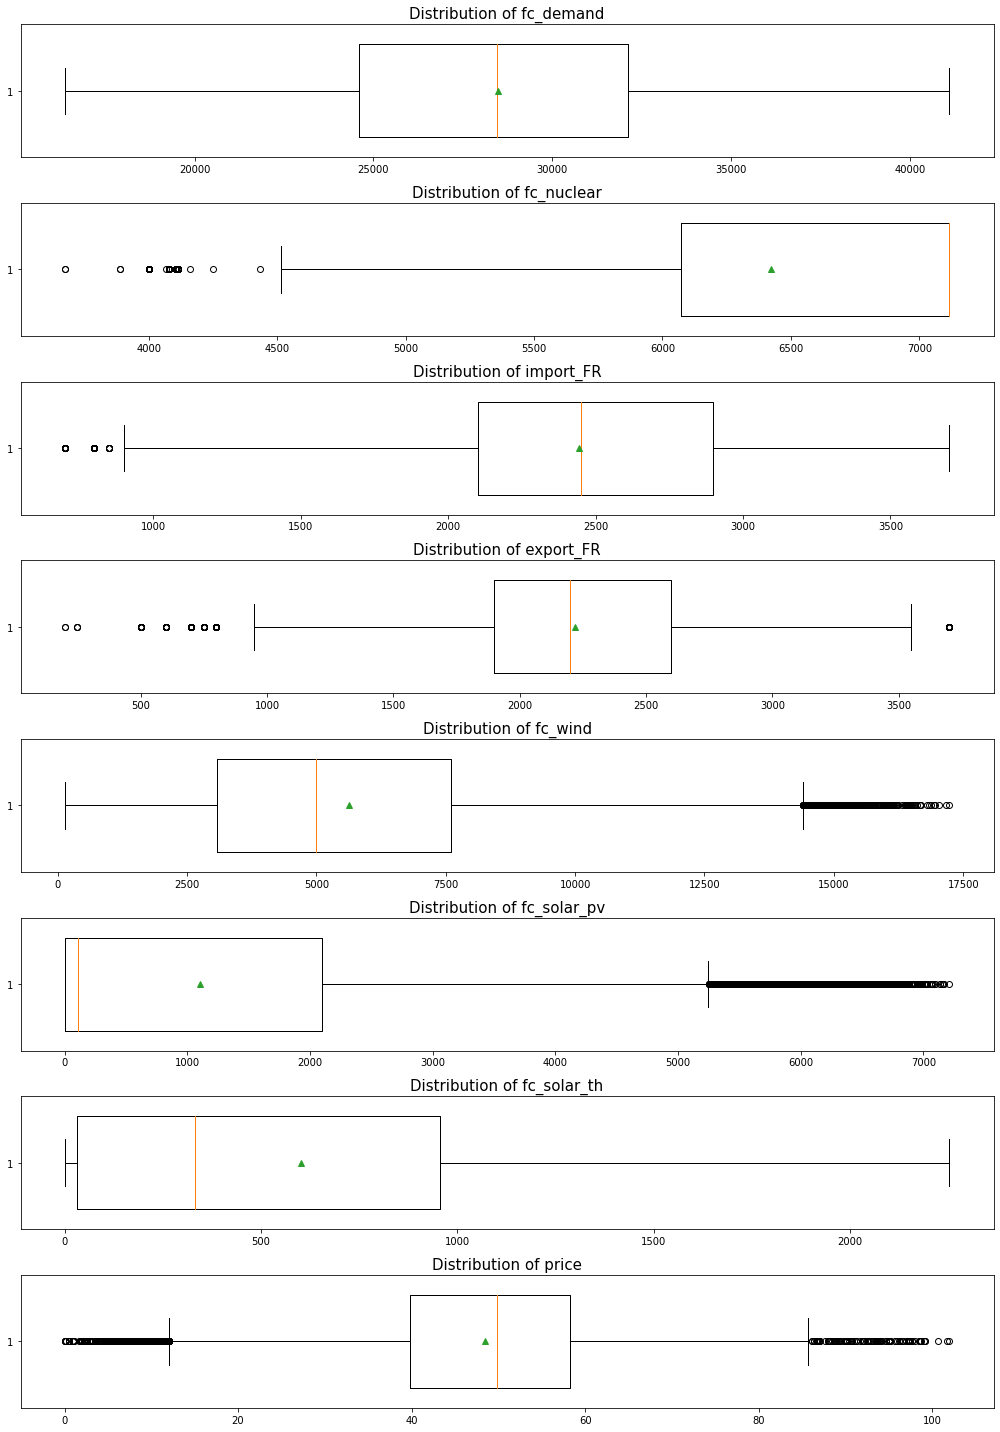

In [42]:
fields = ['fc_demand', 'fc_nuclear', 'import_FR', 'export_FR', 'fc_wind', 'fc_solar_pv', 'fc_solar_th', 'price']
fig, axs = plt.subplots(figsize=(14, 20), ncols=1, nrows=len(fields), sharey=False)
for field, ax in zip(fields, axs):
    ax.set_title('Distribution of ' + field, fontsize=15)
    ax.boxplot(df[field].dropna().values, vert=False, widths=0.7, showmeans=True)
fig.tight_layout()

Contrasting with this second presentation of each variable's distribution, one can classify as outliers those data samples beyond $1.5 \cdot IQR$, $IQR$ being the inter-quartile range of each column. In particular:
* **fc_demand** may appear centered, but it is necessary to take the possible "two modes" of demand into account.
* **fc_nuclear** presents some outliers since its median is also its maximum value. The categorization into 5 possible modes makes sense.
* **import_FR and export_FR** are significantly spread out, but not enough to avoid some data samples being classified as outliers. Since these outliers are just a few, it may be possible to let them be.
* **fc_wind** is significantly skewed and as a result contains a large number of outliers. Perhaps a Box-Cox normalization directly ends with these outlier values.
* Whereas it still makes sense to categorize **fc_solar_pv** to 0 when the original value is 0, and 1 when it is not, the box-plot of **fc_solar_th** makes one think that it might be more sensible to normalize the variable, since the deviation of its median from its mean is not as significant.
* **price** has a large amount of outlier variables at each side. One needs to see what happens to them once the variable is normalized.

### 2.5 Correlations between Features
For determining:
* What columns affect most significantly on the target variable
* What columns present redundant information

It is useful to examine the correlation matrix of all columns in the dataframe.

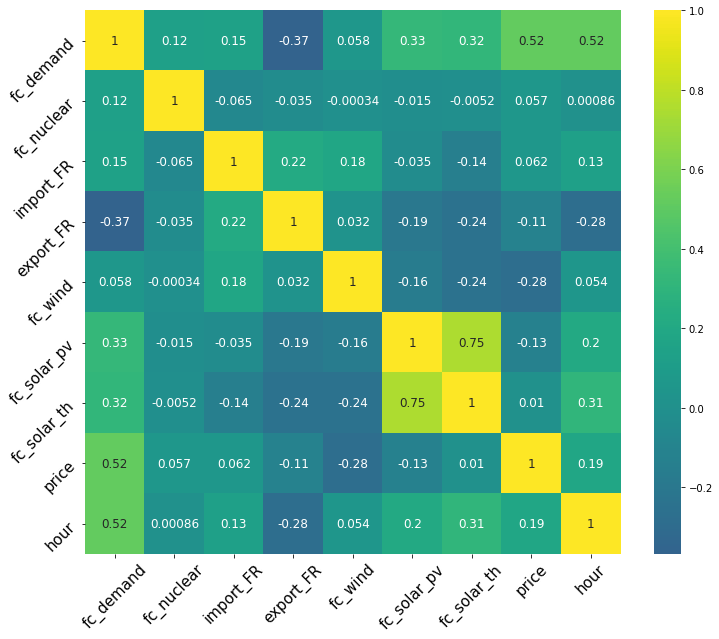

In [44]:
fig, ax = plt.subplots(figsize=(12, 10))
corr_mat = sns.heatmap(df.corr(), annot=True, cmap='viridis', ax=ax, center=0, annot_kws={"fontsize":12})
xtick_labels = corr_mat.get_xmajorticklabels()
ytick_labels = corr_mat.get_ymajorticklabels()
_ = corr_mat.set_xticklabels(xtick_labels, fontsize = 15, rotation=45)
_ = corr_mat.set_yticklabels(ytick_labels, fontsize = 15, rotation=45)

From this correlation matrix, one can extract the following:
* 'fc_demand', 'hour' are the most positively correlated columns with 'price', whereas 'fc_wind', 'export_FR', and 'fc_solar_pv' show notable negative correlations with 'price'.
* 'fc_solar_pv' and 'fc_solar_th' are very strongly correlated. Perhaps it makes sense to combine both into 'fc_solar', since both energy sources depend strongly on the amount of sunlight. However, 'fc_solar_pv' has a stronger relation with 'price' than its thermal counterpart.

Let's plot 'fc_demand', 'hour' 'fc_wind', 'export_FR', and 'fc_solar_pv' with 'price', to visualize their relationships with the target variable.

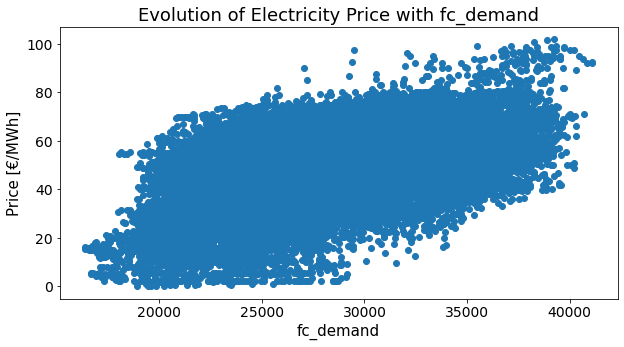

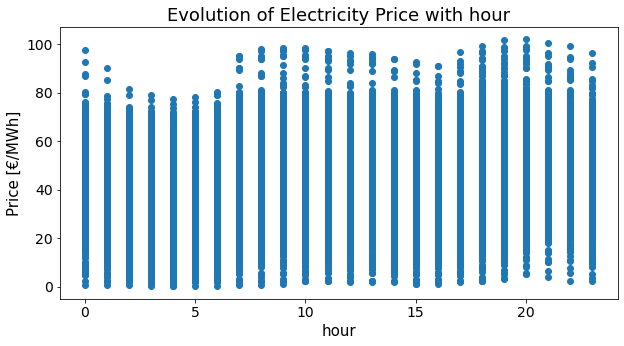

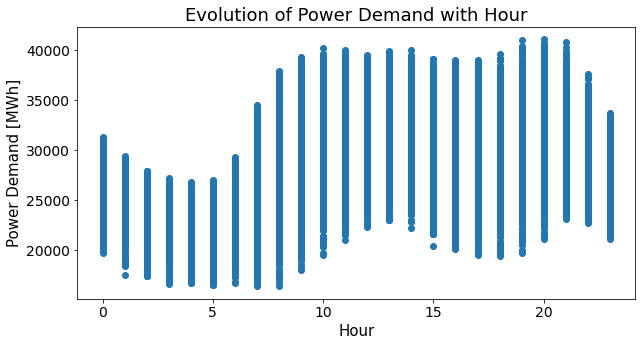

In [52]:
for x in ['fc_demand', 'hour']:
    plt.figure(figsize=(10, 5))
    plt.title('Evolution of Electricity Price with ' + x, fontsize=18)
    plt.scatter(df[x], df['price'])
    plt.xlabel(x, fontsize=15)
    plt.ylabel('Price [€/MWh]', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.figure(figsize=(10, 5))
plt.title('Evolution of Power Demand with Hour', fontsize=18)
plt.scatter(df['hour'], df['fc_demand'])
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Power Demand [MWh]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

From these three scatter plots, one can see that 'price', 'fc_demand', and 'hour' are significantly intertwined. 
* By looking at the evolution of daily demand, it is clear that power demand is much higher from 9:00 to 21:00 than it is during the rest of the day, with a peak at around 19:00. 
* On the other hand, it is clearly visible, as is expected, that demand and price are positively correlated in a straight-forward fashion.
* As a result, the evolution of electricity price with 'hour' is similar to the evolution of demand.

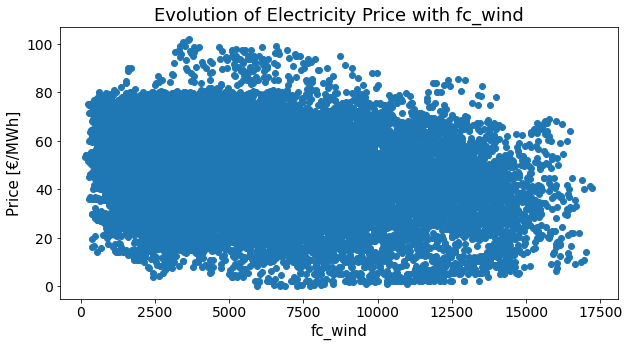

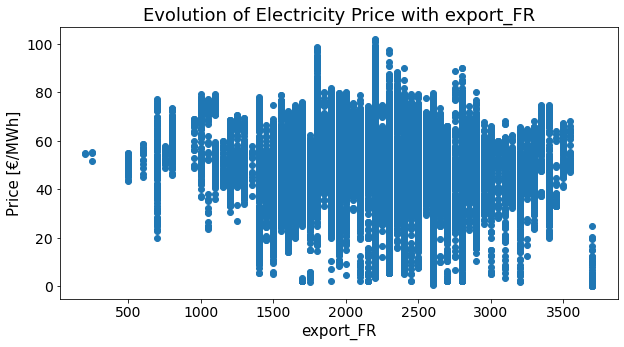

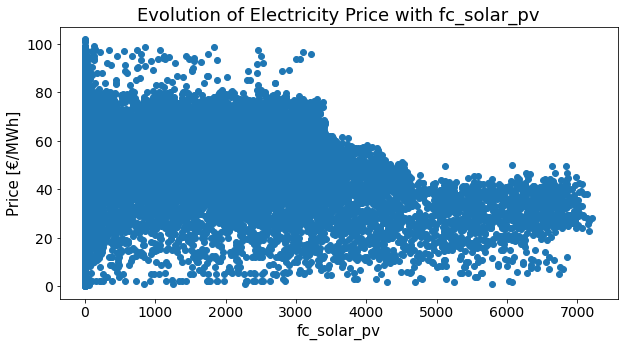

In [50]:
for x in ['fc_wind', 'export_FR', 'fc_solar_pv']:
    plt.figure(figsize=(10, 5))
    plt.title('Evolution of Electricity Price with ' + x, fontsize=18)
    plt.scatter(df[x], df['price'])
    plt.xlabel(x, fontsize=15)
    plt.ylabel('Price [€/MWh]', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

These three last scatter plots, on the other hand, show negative correlations between the variable and 'price'.
* 'fc_solar_pv' shows the most significant negative correlation. Taking into account the distribution of the variable, where it is very frequently 0, one can see that for large values of 'fc_solar_pv', the electricity price decreases significantly.
* 'fc_wind' shows a less markedly negative correlation, perhaps because its distribution is less skewed.
* 'export_FR' does not show any signficant trend in this plot, although of these three, it has the most negative correlation.

## 3. Feature Engineering

Hello guys, based on the EDA, this is what I think we should do with each variable:
* **date**: Generate the following additional columns (as was done in the Python assignment)
    * Month: Not used to predict but for creating other features
    * Winter: 1 if date is winter, Summer, Spring, Fall
    * Weekend: 1 if df['date'].dt.dayofweek > 5.
    * Holiday: 1 if is holiday, don't use US holidays, investigate pandas.tseries.holidays
* **hour**: normalize it with scikit-learn's `PowerTransformer`. Also, generate :
    * Sunlight: Obtain table of sunrise and sunset, and classify each hour depending on if it is during day or during night. Create a CSV based on https://www.datosmundial.com/europa/espana/puesta-del-sol.php. (See how it was done in the Python assignment)
    * Maybe a column saying if the news are being emmitted??? Basically is 1 at 8 am and 9 pm.
* **fc_demand**: Normalize with `PowerTransformer` or only rescale. 
* **fc_nuclear**: I think we could convert this into a categorical variable, equal to 1 if fc_nuclear is close to 7000, and 0 otherwise. This might be more descriptive. See sklearn.preprocessing.KBinsDiscretizer
* **import_FR and export_FR**: Normalize or only rescale. 
* **fc_wind**: This feature is very skewed, so it definitely needs a `PowerTransformer`. See (with a boxplot) if after notmalization there are still outliers.
* **fc_solar_pv**: This one could be converted to a categorical variable, equal to 0 when fc_solar_pv is close to 0, and equal to 1 otherwise. Again, see sklearn.preprocessing.KBinsDiscretizer.
* **fc_solar_th**: Either the same as fc_solar_pv or apply `PowerTransformer`. 
* **price**: Normalize with `PowerTransformer` or only rescale. 
* Also, define **thermal_gap**, and ratios between demand and each production column

For each of the numerical columns, I would plot the histogram or boxplot before and after the transformation, so that the effect is clear. Then, define a large `ColumnTransformer`, applying the transformations to each of the columns of df. Note that the `ColumnTransformer` can't define new columns, but will transform the ones already created.

Then, see the correlation matrix that results

## 4. Choosing and Training a Model

If you look at the Python assignment, I think you can pretty much copy much of what was done there. **However, make sure you use `sklearn.model_selection.TimeSeriesSplit` for cross-validating.**